# Problem statement

You are required to build a model to predict house prices in the Belgium Real State Market, the idea is that when users want to buy a new house, they can compare the listed price with the model prediction and check if it the prices are similar and take a decision, they can use this prediction to start a negotiation with the owners.  Owners can also use this prediction to see if their property is priced correctly not very high and not very low.

This is clearly a regression problem and we could scikit-learn algorithms to find a model, however for this specific problem I wanted to investigate a bit more and step out of my confort zone with the main stream algorithms everybody knows and loves.

After some research  I discovered the following knowledge :), keep reading to understand why I selected LightGBM

## Ensemble methods

Ensemble learning is a machine learning paradigm where multiple models (often called “weak learners”) are trained to solve the same problem and combined to get better results. The main hypothesis is that when weak models are correctly combined we can obtain more accurate and/or robust models

![Ensemble](Ensemble.png "Ensemble")
![Ensemble methods](Ensemble2.png "Ensemble methods")


### Bagging

Bagging, also known as Bootstrap aggregation, is an ensemble learning method that looks for different ensemble learners by varying the training dataset. Unlike a single model trained on the entire dataset, bagging creates multiple weak learners or base models trained on a subset of the original dataset. The number of models to use and the size of the subsets is decided by the data scientist building the model. The data subsets used to train the weak models are generated by random sampling with replacement in each new model trained. Replacement implies that the sample of the data subset used to train each model may have duplicate data

![bagging](bagging.png "bagging")

### Boosting

Boosting is an ensemble modeling technique that attempts to build a strong predictor from the number of weak models. It is done by building a model by using weak models in series. Firstly, a model is built from the training data. Then the second model is built which tries to correct the errors present in the first model. This procedure is continued and models are added until either the complete training data set is predicted correctly or the maximum number of models is added.

![bagging vs boosting](baggingvsboosting.png "bagging vs boosting")


### Gradient Boosting

Gradient boosting re-defines boosting as a numerical optimisation problem where the objective is to minimise the loss function of the model by adding weak learners using gradient descent. Gradient descent is a first-order iterative optimisation algorithm for finding a local minimum of a differentiable function. As gradient boosting is based on minimising a loss function, different types of loss functions can be used resulting in a flexible technique that can be applied to regression, multi-class classification, etc.


After reading about Ensemble Methods and Gradient Boosting I discovered Microsoft has an implementation of Gradient Boosting called LightGBM so I decided to give it a try.


### LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

1. Faster training speed and higher efficiency.
2. Lower memory usage.
3. Better accuracy.
4. Support of parallel, distributed, and GPU learning.
5. Capable of handling large-scale data.

We will see later the hyperparameters dictionary and how to set it up, but in the meantime these are some important parameters (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

1. num_leaves. This is the main parameter to control the complexity of the tree model. Theoretically, we can set num_leaves = 2^(max_depth) to obtain the same number of leaves as depth-wise tree. However, this simple conversion is not good in practice. The reason is that a leaf-wise tree is typically much deeper than a depth-wise tree for a fixed number of leaves. Unconstrained depth can induce over-fitting. Thus, when trying to tune the num_leaves, we should let it be smaller than 2^(max_depth). For example, when the max_depth=7 the depth-wise tree can get good accuracy, but setting num_leaves to 127 may cause over-fitting, and setting it to 70 or 80 may get better accuracy than depth-wise.

2. min_data_in_leaf. This is a very important parameter to prevent over-fitting in a leaf-wise tree. Its optimal value depends on the number of training samples and num_leaves. Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset.

3. max_depth. You also can use max_depth to limit the tree depth explicitly.


### Packages required

We need LightGBM and the usual suspects, pandas, matplotlib and finally graphviz for visualization.

In [ ]:
%pip install lightgbm
%pip install pandas
%pip install matplotlib
%pip install graphviz 

Then we need to import the following types

In [2]:
import lightgbm as lgb
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas import DataFrame
from pandas import Series, DataFrame 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder


## Load the data.

We read a copy of the csv file from the current path and we specify the column names and separators if needed.


In [3]:
data =  pd.read_csv('realstate.csv', sep='\t',names=('col_0', 
    'postal_code', 
    'city_name', 
    'type_of_property',
    'price',
    'number_of_rooms',
    'house_area',
    'fully_equipped_kitchen',
    'open_fire',
    'terrace',
    'garden',
    'surface_of_the_land',
    'number_of_facades',
    'swimming_pool',
    'state_of_the_building',
    'lattitude',
    'longitude',
    'province',
    'region'
    ))

data

,col_0,postal_code,city_name,type_of_property,price,number_of_rooms,house_area,fully_equipped_kitchen,open_fire,terrace,garden,surface_of_the_land,number_of_facades,swimming_pool,state_of_the_building,lattitude,longitude,province,region
0,1,1050,Ixelles,0,520000,4,200,0,0,0,0,69,2,0,to renovate,4.381571,50.822285,Bruxelles-Capitale,Bruxelles
1,2,1050,Ixelles,0,599000,4,160,1,0,1,1,100,2,0,to be done up,4.381571,50.822285,Bruxelles-Capitale,Bruxelles
2,3,1050,Ixelles,0,599000,3,160,1,0,1,1,130,2,0,good,4.381571,50.822285,Bruxelles-Capitale,Bruxelles
3,4,1050,Ixelles,0,575000,3,171,0,0,0,0,46,2,0,just renovated,4.381571,50.822285,Bruxelles-Capitale,Bruxelles
4,5,1050,Ixelles,0,590000,4,225,0,0,1,0,0,2,0,to renovate,4.381571,50.822285,Bruxelles-Capitale,Bruxelles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35411,40390,1472,Vieux-Genappe,0,475000,5,216,1,1,0,0,1550,4,1,as new,4.401503,50.629025,Brabant wallon,Wallonie
35412,40391,1472,Vieux-Genappe,0,475000,5,215,1,0,1,0,1550,0,1,good,4.401503,50.629025,Brabant wallon,Wallonie
35413,40392,1461,Haut-Ittre,0,499000,5,275,1,0,1,1,1561,4,0,unknown,4.296472,50.648804,Brabant wallon,Wallonie
35414,40393,1761,Borchtlombeek,0,495000,4,235,1,0,0,1,488,4,0,unknown,4.136915,50.848178,Brabant flamand,Flandre


# Drop columns

Some columns will not have any impact on the price, the ID, Provice, Region and Location Data.  I dropped postal code, because I already have a column called city name which might have an affect on prices.

In [4]:
data.drop(['col_0','postal_code','province','region','lattitude','longitude'], axis=1, inplace=True)
data.sample(5)


,city_name,type_of_property,price,number_of_rooms,house_area,fully_equipped_kitchen,open_fire,terrace,garden,surface_of_the_land,number_of_facades,swimming_pool,state_of_the_building
983,Brugge,0,399000,4,164,0,0,0,1,172,0,0,as new
21027,Molenbeek-Saint-Jean,1,157000,2,70,1,0,1,0,0,2,0,unknown
28283,Aalter,1,230000,2,89,0,0,1,0,0,0,0,as new
3531,Forest,1,195000,1,76,1,0,1,1,0,3,0,just renovated
2804,Berchem-Sainte-Agathe,0,455000,3,210,1,1,1,0,142,2,0,to be done up


Then we are going to use OneHotEncoder fo the State of the building which is a category with a few options, so a new column will be created for each option and a 1 or 0 will be put accordingly

In [5]:
one_hot_state_of_the_building=pd.get_dummies(data.state_of_the_building) 

#removing categorical features 
data.drop(['state_of_the_building'],axis=1,inplace=True) 

#Merging one hot encoded features with our dataset 'data' 
data=pd.concat([data,one_hot_state_of_the_building,],axis=1) 
data



,city_name,type_of_property,price,number_of_rooms,house_area,fully_equipped_kitchen,open_fire,terrace,garden,surface_of_the_land,number_of_facades,swimming_pool,as new,good,just renovated,to be done up,to renovate,to restore,unknown
0,Ixelles,0,520000,4,200,0,0,0,0,69,2,0,0,0,0,0,1,0,0
1,Ixelles,0,599000,4,160,1,0,1,1,100,2,0,0,0,0,1,0,0,0
2,Ixelles,0,599000,3,160,1,0,1,1,130,2,0,0,1,0,0,0,0,0
3,Ixelles,0,575000,3,171,0,0,0,0,46,2,0,0,0,1,0,0,0,0
4,Ixelles,0,590000,4,225,0,0,1,0,0,2,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35411,Vieux-Genappe,0,475000,5,216,1,1,0,0,1550,4,1,1,0,0,0,0,0,0
35412,Vieux-Genappe,0,475000,5,215,1,0,1,0,1550,0,1,0,1,0,0,0,0,0
35413,Haut-Ittre,0,499000,5,275,1,0,1,1,1561,4,0,0,0,0,0,0,0,1
35414,Borchtlombeek,0,495000,4,235,1,0,0,1,488,4,0,0,0,0,0,0,0,1


The city name can also be seen as a category, but in this case it has too many options (all Belgium Cities), if we use OneHotEncoder then 1000 new features will be created.
In this case I will use LabelEncoder which changes the city string by a category in form of an integer value

In [6]:
from sklearn.preprocessing import LabelEncoder
cat_feats = [ 'city_name']
labelencoder = LabelEncoder()

for col in cat_feats:
    data[col] = labelencoder.fit_transform(data[col])

for col in cat_feats:
    data[col] = data[col].astype('int')
    

df_predict= data[0:0] 

In [7]:
#Lets see how the data looks like
data.describe()

,city_name,type_of_property,price,number_of_rooms,house_area,fully_equipped_kitchen,open_fire,terrace,garden,surface_of_the_land,number_of_facades,swimming_pool,as new,good,just renovated,to be done up,to renovate,to restore,unknown
count,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000,35416.000000
mean,500.406426,0.498560,296697.054269,2.675006,142.406455,0.698950,0.046307,0.630026,0.316693,419.302349,2.024255,0.012876,0.310509,0.272645,0.053450,0.065140,0.049639,0.002146,0.246471
std,297.664201,0.500005,120400.433352,0.995590,75.733846,0.458721,0.210152,0.482804,0.465193,2268.667246,1.414994,0.112739,0.462709,0.445326,0.224933,0.246776,0.217200,0.046275,0.430962
min,0.000000,0.000000,120000.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,253.000000,0.000000,209000.000000,2.000000,91.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,502.000000,0.000000,270000.000000,3.000000,125.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,733.000000,1.000000,359000.000000,3.000000,174.000000,1.000000,0.000000,1.000000,1.000000,377.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1019.000000,1.000000,680000.000000,5.000000,2019.000000,1.000000,1.000000,1.000000,1.000000,120300.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Then we need to split the data, on one side we put all features, on other side we put our target, the price.

In [8]:
x=data.drop('price',axis=1) 
y=data.price 

In order to use LightGBM the data must be formatted with their own Dataset class. (lgb.Dataset below)
Then we train test split, 30% for testing, 70% for training

In [9]:
X_df = DataFrame(x, columns= data.columns)
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.30)
d_train=lgb.Dataset(X_train, label=y_train)

Then we can define the hyper parameters for LightGBM and use the test dataset for validation and finding the RMSE. Note we already explained the most important parameters above, I left as an exercise to the reader to find the best combination of hyper parameters by reading the documentation.

In [10]:

import math
#Declaring the parameters
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'metric': {'l2','l1'},
    'verbose': -1,
    'max_depth':12
}

#model creation and training
clf=lgb.train(params,d_train,10000)

#model prediction on X_test
y_pred=clf.predict(X_test)

#using RMSE error metric
mse =mean_squared_error(y_pred,y_test)
rmse = math.sqrt(mse)
print(rmse)

74749.88941035283


Then we can plot the feature importance for the model

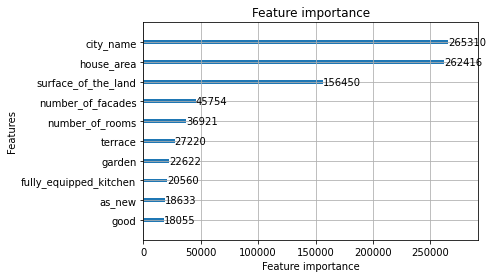

In [11]:
ax = lgb.plot_importance(clf, max_num_features=10)
plt.show()

Or we can plot the decision tree

In [ ]:
#lgb.plot_tree(clf, tree_index = 0, figsize=(80,80))

In [20]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "download.png")

We build 2 dictionaries with the features and values, and then we add it to  a pandas dataframe, when we can predict on unseen data.

In [17]:
# Lets predict


df_predict
dict = {
    'city_name': 'Ixelles',
    'type_of_property': 0,
    'price': 0,
    'number_of_rooms':3, 
    'house_area':180, 
    'fully_equipped_kitchen':1,
    'open_fire':0,
    'terrace':1,
    'garden':0, 
    'surface_of_the_land':120,
    'number_of_facades':1,
    'swimming_pool':0,
    'as new':0,
    'good':0,
    'just renovated':0,
    'to be done up':1,
    'to renovate':0,
    'to restore':0,
    'unknown':0
    }

dict2 = {
    'city_name': 'Ixelles',
    'type_of_property': 0,
    'price': 0,
    'number_of_rooms':3, 
    'house_area':180, 
    'fully_equipped_kitchen':1,
    'open_fire':0,
    'terrace':1,
    'garden':0, 
    'surface_of_the_land':120,
    'number_of_facades':1,
    'swimming_pool':0,
    'as new':1,
    'good':0,
    'just renovated':0,
    'to be done up':0,
    'to renovate':0,
    'to restore':0,
    'unknown':0
    }

df_predict = pd.DataFrame([dict, dict2])

# We need to use the same LabelEncoder to get the same number for
# the city name

for col in cat_feats:
    df_predict[col] = labelencoder.fit_transform(df_predict[col])
for col in cat_feats:
    df_predict[col] = df_predict[col].astype('int')

price  = clf.predict(df_predict,predict_disable_shape_check=True)
price


array([218026.54081757, 273479.98299595])

# Further Steps

If you check the RMSE above, which is around 75K, for a house price of 700,000 the RMSE is about 10%, which in % does not seem too high, but if our price prediction is wrong by 75.000 euros, in real life thats a big amount of money, both for the seller and the buyer.

In order to improve this model, my next would be to try different values for each hyper parameter based on the documentation,  I would also do some auto hyper parameter tuning with GridSearch or another framework.

## Operationalize

How would I put this into production?  We need to take into account data drift, property prices go high every year, which means we need to update the model on a recurrent basis. The best way to do it is by implementing MLOPs

### ML OPS

MLOps or ML Ops is a set of practices that aims to deploy and maintain machine learning models in production reliably and efficiently. The word is a compound of "machine learning" and the continuous development practice of DevOps in the software field

With Azure Devops we can implement ML Ops by  creating pipelines for Data loading, cleaning and preparation, training, scoring and deployment.  In this case we would get data from a trusted source on a daily or weekly basis, and based on the new data we get every run, we can re-train the model to improve the model predictions, and if the model is better at some point, we can swith the deployed model.



I hope you found this Project useful and you can take it from here to improve the model.